<a href="https://colab.research.google.com/github/BillWorstell/DiffDRR/blob/main/iMyCheckDRRs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up DiffDRR environment

In [1]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html


Install icecream for debug printing

https://github.com/gruns/icecream

In [2]:
!pip install icecream
from icecream import ic

From https://github.com/rossbar/derenzo_phantom

From derenzo_log.py

In [3]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpp

https://vivekg.dev/DiffDRR/

Usage

The following minimal example specifies the geometry of the projectional radiograph imaging system and traces rays through a CT volume:

#Install DiffDRR

Use the version of DiffDRR posted on github

In [4]:
!pip install 'git+https://github.com/BillWorstell/DiffDRR.git'

  Cloning https://github.com/BillWorstell/DiffDRR.git to /tmp/pip-req-build-jv5cxvff
  Running command git clone --filter=blob:none --quiet https://github.com/BillWorstell/DiffDRR.git /tmp/pip-req-build-jv5cxvff
  Resolved https://github.com/BillWorstell/DiffDRR.git to commit 096b8575b3e2ededb06901637a3657a78c96d2ae
  Preparing metadata (setup.py) ... done


#MyDRR from DRR

https://github.com/BillWorstell/DiffDRR/blob/main/00_drr.ipynb

In [5]:
#| default_exp drr

In [6]:
!pip install nbdev

In [7]:
#| hide
from nbdev.showdoc import *

In [8]:
#| export
from __future__ import annotations

import numpy as np
import torch
import torch.nn as nn
from fastcore.basics import patch

from diffdrr.detector import Detector
from diffdrr.siddon import siddon_raycast

In [9]:
#| export
class MyDRR(nn.Module):
    """PyTorch module that computes differentiable digitally reconstructed radiographs."""

    def __init__(
        self,
        volume: np.ndarray,  # CT volume
        spacing: np.ndarray,  # Dimensions of voxels in the CT volume
        sdr: float,  # Source-to-detector radius for the C-arm (half of the source-to-detector distance)
        height: int,  # Height of the rendered DRR
        delx: float,  # X-axis pixel size
        width: int | None = None,  # Width of the rendered DRR (if not provided, set to `height`)
        dely: float | None = None,  # Y-axis pixel size (if not provided, set to `delx`)
        x0: float = 0.0,  # Principal point X-offset
        y0: float = 0.0,  # Principal point Y-offset
        p_subsample: float | None = None,  # Proportion of pixels to randomly subsample
        reshape: bool = True,  # Return DRR with shape (b, 1, h, w)
        reverse_x_axis: bool = False,  # If pose includes reflection (in E(3) not SE(3)), reverse x-axis
        patch_size: int | None = None,  # If the entire DRR can't fit in memory, render patches of the DRR in series
        bone_attenuation_multiplier: float = 1.0,  # Contrast ratio of bone to soft tissue
    ):
        super().__init__()

        # Initialize the X-ray detector
        width = height if width is None else width
        dely = delx if dely is None else dely
        n_subsample = (
            int(height * width * p_subsample) if p_subsample is not None else None
        )
        self.detector = Detector(
            sdr,
            height,
            width,
            delx,
            dely,
            x0,
            y0,
            n_subsample=n_subsample,
            reverse_x_axis=reverse_x_axis,
        )

        # Initialize the volume
        self.register_buffer("spacing", torch.tensor(spacing))
        self.register_buffer("volume", torch.tensor(volume).flip([0]))
        self.reshape = reshape
        self.patch_size = patch_size
        if self.patch_size is not None:
            self.n_patches = (height * width) // (self.patch_size**2)

        # Parameters for segmenting the CT volume and reweighting voxels
        self.air = torch.where(self.volume <= -800)
        self.soft_tissue = torch.where((-800 < self.volume) & (self.volume <= 350))
        self.bone = torch.where(350 < self.volume)
        self.bone_attenuation_multiplier = bone_attenuation_multiplier

    def reshape_transform(self, img, batch_size):
        if self.reshape:
            if self.detector.n_subsample is None:
                img = img.view(-1, 1, self.detector.height, self.detector.width)
            else:
                img = reshape_subsampled_drr(img, self.detector, batch_size)
        return img

The forward pass of the DRR module generated DRRs from the input CT volume. The pose parameters (i.e., viewing angles) from which the DRRs are generated are passed to the forward call.

In [10]:
#| export
from pytorch3d.transforms import Transform3d

from diffdrr.detector import make_xrays


@patch
def forward(
    self: MyDRR,
    rotation: torch.Tensor,
    translation: torch.Tensor,
    parameterization: str,
    convention: str = None,
    pose: Transform3d = None,  # If you have a preformed pose, can pass it directly
    bone_attenuation_multiplier: float = None,  # Contrast ratio of bone to soft tissue
):
    """Generate DRR with rotational and translational parameters."""
    if not hasattr(self, "density"):
        self.set_bone_attenuation_multiplier(self.bone_attenuation_multiplier)
    if bone_attenuation_multiplier is not None:
        self.set_bone_attenuation_multiplier(bone_attenuation_multiplier)

    if pose is None:
        assert len(rotation) == len(translation)
        batch_size = len(rotation)
        source, target = self.detector(
            rotation=rotation,
            translation=translation,
            parameterization=parameterization,
            convention=convention,
        )
    else:
        batch_size = len(pose)
        source, target = make_xrays(pose, self.detector.source, self.detector.target)

    if self.patch_size is not None:
        n_points = target.shape[1] // self.n_patches
        img = []
        for idx in range(self.n_patches):
            t = target[:, idx * n_points : (idx + 1) * n_points]
            partial = siddon_raycast(source, t, self.density, self.spacing)
            img.append(partial)
        img = torch.cat(img, dim=1)
    else:
        img = siddon_raycast(source, target, self.density, self.spacing)
    return self.reshape_transform(img, batch_size=batch_size)

In [11]:
#| exporti
@patch
def set_bone_attenuation_multiplier(self: MyDRR, bone_attenuation_multiplier: float):
    self.density = torch.empty_like(self.volume)
    self.density[self.air] = self.volume[self.soft_tissue].min()
    self.density[self.soft_tissue] = self.volume[self.soft_tissue]
    self.density[self.bone] = self.volume[self.bone] * bone_attenuation_multiplier
    self.density -= self.density.min()
    self.density /= self.density.max()
    self.bone_attenuation_multiplier = bone_attenuation_multiplier

def inverse_projection(
    self: MyDRR,
    pose: RigidTransform,
    pts: torch.Tensor,
):
    extrinsic = self.detector.reorient.compose(pose)
    x = self.detector.sdd * torch.einsum(
        "ij, bnj -> bni",
        self.detector.intrinsic.inverse(),
        pad(pts, (0, 1), value=1),  # Convert to homogenous coordinates
    )
    return extrinsic(x)

##BackProject

In [12]:
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

Git clone from github publib open source code to colab working directory

See https://stackoverflow.com/questions/50850216/google-colab-install-from-github-glrm

Read in the volume and get the isocenter

In [13]:
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx, by, bz)
ic(volume.shape)
ic(spacing)

ic| bx: tensor(180.), by: tensor(180.), bz: tensor(166.2500)
ic| volume.shape: (512, 512, 133)
ic| spacing: [0.703125, 0.703125, 2.5]


[0.703125, 0.703125, 2.5]

Sum volume over orthogonal projections

SumX = Volumes summed over X (YZ projection

SumY = Volumes summed over Y (YZ projection)

SumZ = Volumes summed over Z (YZ projection))

In [14]:
ic(volume.shape)
SumX=volume.sum(0)
SumY=volume.sum(1)
SumZ=volume.sum(2)
ic(SumX.shape)
ic(SumY.shape)
ic(SumZ.shape)

ic| volume.shape: (512, 512, 133)
ic| SumX.shape: (512, 133)
ic| SumY.shape: (512, 133)
ic| SumZ.shape: (512, 512)


(512, 512)

#Get derenzo_phantom version from github

In [15]:
!rm /content/derenzo_phantom -rf
!git clone https://github.com/Billworstell/derenzo_phantom.git

Cloning into 'derenzo_phantom'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 209 (delta 61), reused 89 (delta 42), pack-reused 70
Receiving objects: 100% (209/209), 24.63 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (94/94), done.


look around

In [16]:
!pwd
!ls -ltr

# importing module
import sys

# printing all directories for
# interpreter to search
sys.path.append('/content/derenzo_phantom/')

!ls -ltr /content
!ls -ltr /content/derenzo_phantom/
!ls -ltr /content/derenzo_phantom/derenzo_log.py

/content
total 12
drwxr-xr-x 1 root root 4096 Apr 30 13:20 sample_data
drwx------ 5 root root 4096 May  2 17:14 drive
drwxr-xr-x 3 root root 4096 May  2 17:20 derenzo_phantom
total 12
drwxr-xr-x 1 root root 4096 Apr 30 13:20 sample_data
drwx------ 5 root root 4096 May  2 17:14 drive
drwxr-xr-x 3 root root 4096 May  2 17:20 derenzo_phantom
total 24952
-rw-r--r-- 1 root root  519246 May  2 17:20  CallDiffDRR.ipynb
-rw-r--r-- 1 root root   36768 May  2 17:20  CollectiveDiffDRR.ipynb
-rw-r--r-- 1 root root 1313334 May  2 17:20 'DeRenzo Pytomography.pdf'
-rw-r--r-- 1 root root 1545339 May  2 17:20 'DeRenzo iCheckRotations ipynb.pdf'
-rw-r--r-- 1 root root  741844 May  2 17:20  DeRenzoRandomPytomography.pdf
-rw-r--r-- 1 root root 1803321 May  2 17:20  DerenzoPytomography.ipynb
-rw-r--r-- 1 root root  578765 May  2 17:20 'Homogeneous coordinate backprojection and reprojection.pdf'
-rw-r--r-- 1 root root 3995375 May  2 17:20 'Learned Multiperspective 3-D CT reconstruction using PyTorch3D .pdf'

import DerenzoPhantom

In [17]:
from phantom import DerenzoPhantom

Use reference phantom

ic| SectorMask.sum(): 28818.0
ic| self.mask.sum(): 28818.0
ic| SectorMask.sum(): 16216.0
ic| self.mask.sum(): 45034.0
ic| SectorMask.sum(): 11257.0
ic| self.mask.sum(): 56291.0
ic| SectorMask.sum(): 14414.0
ic| self.mask.sum(): 70705.0
ic| SectorMask.sum(): 20275.0
ic| self.mask.sum(): 90980.0
ic| SectorMask.sum(): 16790.0
ic| self.mask.sum(): 107770.0


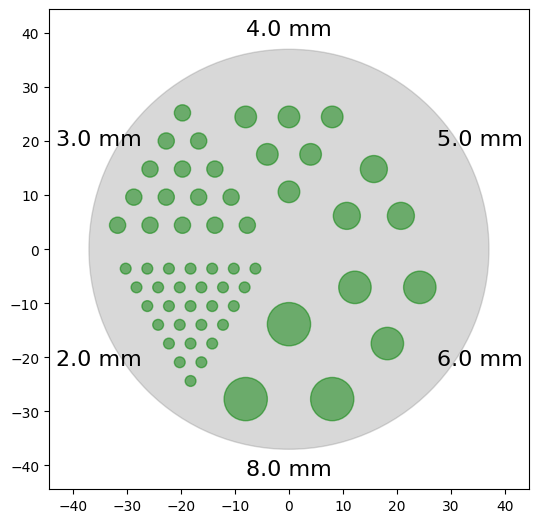

In [18]:
radius = 37.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
test_phantom = DerenzoPhantom(radius, well_seps, )
test_phantom.show()

Generate Mask for reference phantom

ic| myMask.shape: (1024, 1024)
ic| myMask.sum(): 107770.0


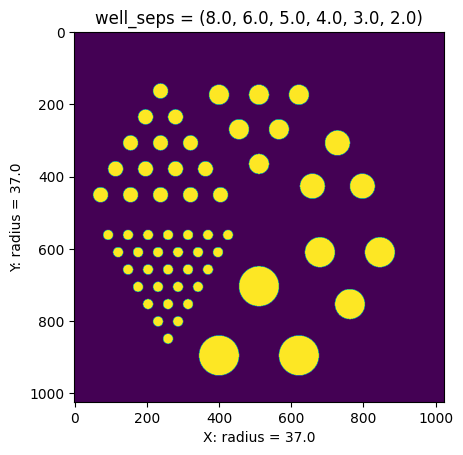

In [19]:
myMask=test_phantom.mask.reshape(1024,1024)
ic(myMask.shape)
ic(myMask.sum())
#plt.imshow(myMask)
plt.imshow(np.flipud(myMask))

plt.title('well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)')
plt.xlabel('X: radius = 37.0')
plt.ylabel('Y: radius = 37.0')
plt.show()

make meshgrid from volume and spacing

In [20]:
#volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx, by, bz)
ic(volume.shape)
ic(spacing)

ic| bx: tensor(180.), by: tensor(180.), bz: tensor(166.2500)
ic| volume.shape: (512, 512, 133)
ic| spacing: [0.703125, 0.703125, 2.5]


[0.703125, 0.703125, 2.5]

Get lab frame coordinates for voxels in volume

In [21]:
    xlinspace=np.linspace(-256*spacing[0], 256*spacing[0], 512)
    ylinspace=np.linspace(-256*spacing[1], 256*spacing[1], 512)
    zlinspace=np.linspace(-66.5*spacing[2], 66.5*spacing[2], 133)
    xgrid,ygrid,zgrid = np.meshgrid(xlinspace, ylinspace,zlinspace)
    xgrid=xgrid.flatten()
    ygrid=ygrid.flatten()
    zgrid=zgrid.flatten()


Define rotateImage for psi rotation of phantom, using scipy ndimage

In [22]:
from scipy import ndimage

def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]


Define 3D rotation matrices


In [23]:
# import math for rotation Matrix multiplication
import math as m

def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])

def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])



#Specify 3D Phantom Geometry

with null Rotation=[0,0,0], Translation=[0,0,0]

---



In [24]:
# NULL TRANSLATION AND NULL ROTATION
#
#Hard-wire 100mm tall phantom for the moment
PhantomHalfZ=50.
ic(PhantomHalfZ)
#TranslatePhantom=[30.,40.,50.]
TranslatePhantom=[0.,0.,0.]
ic(TranslatePhantom)

# specify Euler angles for establishing Phantom orientation in lab frame
psi = 0.
#psi=np.pi/4.
#phi=np.pi/4.
phi=0.0
#theta=np.pi/6.
theta=0.0

psiDeg=psi*(180./np.pi)
thetaDeg=theta*(180./np.pi)
phiDeg=phi*(180./np.pi)

RotatePhantom=[phi,theta,psi]
ic(RotatePhantom)

spacingPhantom=[(2.*radius)/1024.,2.*radius/1024.,2.*PhantomHalfZ]
ic(spacingPhantom)

ic| PhantomHalfZ: 50.0
ic| TranslatePhantom: [0.0, 0.0, 0.0]
ic| RotatePhantom: [0.0, 0.0, 0.0]
ic| spacingPhantom: [0.072265625, 0.072265625, 100.0]


[0.072265625, 0.072265625, 100.0]

Position phantom in lab frame by first rotating by psi about initial z, then by theta about y', then by phi about z''

In [25]:
R_Invert=  Ry(-theta) * Rz(-phi)
print(np.round(R_Invert, decimals=2))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [26]:
# Transform from lab frame 'grid' to phantom reference frame through a series of transformations
#
# Invert translation from Lab System origin to Phantom System origin
ic(radius)
ic(PhantomHalfZ)
ic(TranslatePhantom)
xp1 = xgrid-TranslatePhantom[0]
yp1 = ygrid-TranslatePhantom[1]
zp1 = zgrid-TranslatePhantom[2]
ic(xp1.shape)

v1 = np.array([xp1,yp1,zp1])
v2 = R_Invert * v1

xp2=v2[0,:]
yp2=v2[1,:]
zp2=v2[2,:]

xp3=np.squeeze(np.asarray(xp2))
yp3=np.squeeze(np.asarray(yp2))
zp3=np.squeeze(np.asarray(zp2))
ic(xp1)
ic(xp2)
ic(xp3)

ic(xp1.size)
ic(xp1.shape)
ic(xp2.shape)
ic(xp3.shape)

ixPh=np.floor(((xp3+radius)/spacingPhantom[0])).astype(int)
ic(ixPh.max())
ic(ixPh.min())
iyPh=np.floor(((yp3+radius)/spacingPhantom[1])).astype(int)
ic(iyPh.max())
ic(iyPh.min())
#izPh=np.floor(((zp3+PhantomHalfZ)/spacingPhantom[2])).astype(int)
#ic(izPh.max())
#ic(izPh.min())

ic| radius: 37.0
ic| PhantomHalfZ: 50.0
ic| TranslatePhantom: [0.0, 0.0, 0.0]
ic| xp1.shape: (34865152,)
ic| xp1: array([-180., -180., -180., ...,  180.,  180.,  180.])
ic| xp2: matrix([[-180., -180., -180., ...,  180.,  180.,  180.]])
ic| xp3: array([-180., -180., -180., ...,  180.,  180.,  180.])
ic| xp1.size: 34865152
ic| xp1.shape: (34865152,)
ic| xp2.shape: (1, 34865152)
ic| xp3.shape: (34865152,)
ic| ixPh.max(): 3002
ic| ixPh.min(): -1979
ic| iyPh.max(): 3002
ic| iyPh.min(): -1979


-1979

Insert test reference phantom into source volume

In [27]:
# Input test phantom reference mask and rotate by psi
phantomMask=test_phantom.mask.reshape(1024,1024)
pivot=[511,511]
phantomMaskR=rotateImage(phantomMask, psiDeg, pivot)

volumeShape=[512, 512, 133]
phantomShape=[1024,1024]
ic(volumeShape)
volume=np.zeros(volumeShape).flatten()
ic(volume.shape)

ic(min(zp1))
ic(max(zp1))
ic(min(zp3))
ic(max(zp3))
validX=(ixPh>=0) & (ixPh<phantomShape[0])
validY=(iyPh>=0) & (iyPh<phantomShape[1])
validZ=(zp3>=-PhantomHalfZ) & (zp3<=PhantomHalfZ)
valid=(validX & validY & validZ).flatten()
ic(valid.shape)
ixPh2=ixPh[valid]
iyPh2=iyPh[valid]
Test=volume[valid]
ic(Test.shape)

volume=volume*0.
volume[valid]=phantomMaskR[ixPh2,iyPh2]

volume=volume.reshape(volumeShape)
PVCvolume=np.zeros(volume.shape,dtype=np.float32)
PVCvolume[1:511, 1:511, :] += volume[0:510, 0:510, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[0:510, 1:511, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[0:510, 2:512, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[1:511, 0:510, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[1:511, 1:511, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[1:511, 2:512, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[2:512, 0:510, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[2:512, 1:511, :] / 9.
PVCvolume[1:511, 1:511, :] += volume[2:512, 2:512, :] / 9.

ic| volumeShape: [512, 512, 133]
ic| volume.shape: (34865152,)
ic| min(zp1): -166.25
ic| max(zp1): 166.25
ic| min(zp3): -166.25
ic| max(zp3): 166.25
ic| valid.shape: (34865152,)
ic| Test.shape: (438204,)


Display Phantom projections within volume

ic| PVCvolume.shape: (512, 512, 133)
ic| SumX.shape: (512, 133)
ic| SumY.shape: (512, 133)
ic| SumZ.shape: (512, 512)


Text(0.5, 1.0, 'T= [0.0, 0.0, 0.0] R= [psi=0.0, theta=0.0, phi=0.0] ')

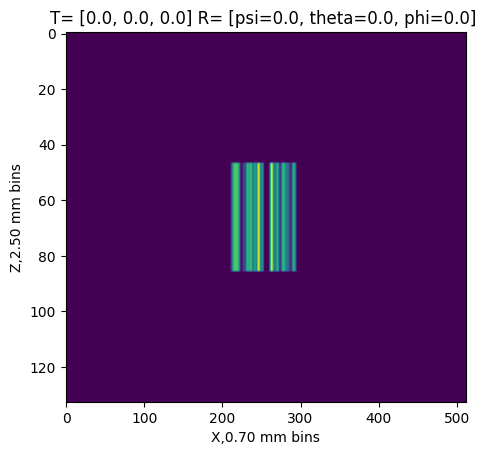

In [28]:
ic(PVCvolume.shape)
SumX=PVCvolume.sum(0)
SumY=PVCvolume.sum(1)
SumZ=PVCvolume.sum(2)
ic(SumX.shape)
ic(SumY.shape)
ic(SumZ.shape)

ThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumX.T),aspect=ThisAspect)
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Text(0.5, 1.0, 'T= [0.0, 0.0, 0.0] R= [psi=0.0, theta=0.0, phi=0.0] ')

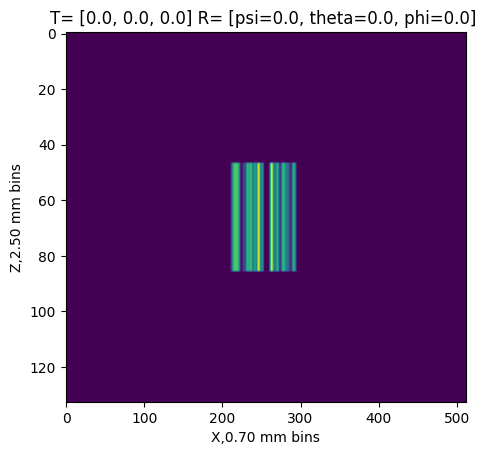

In [29]:
ThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumX.T),aspect=ThisAspect)
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Text(0.5, 1.0, 'T= [0.0, 0.0, 0.0] R= [psi=0.0, theta=0.0, phi=0.0] ')

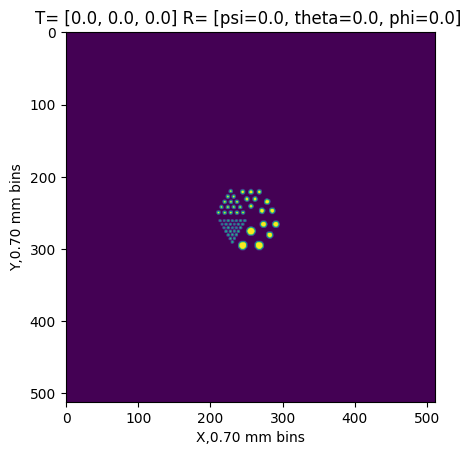

In [30]:
plt.imshow(np.flipud(SumZ.T))
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Y,{spacing[1]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Display axial projection

T= [0.0, 0.0, 0.0] 
R= [psi=0.0, theta=0.0, phi=0.0] 


Text(0, 0.5, 'Y: radius = 37.0, HalfZ= 50.0, voxel =[] 0.07, 0.07, 2.5]')

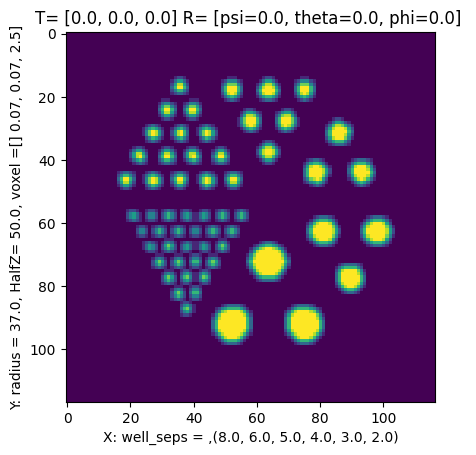

In [31]:
plt.imshow(np.flipud(SumZ[192:309,192:309].T))
psiDeg=(180/np.pi)*psi
thetaDeg=(180/np.pi)*theta
phiDeg=(180/np.pi)*phi
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
print(TranslateString)
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
print(RotateString)
plt.title(TranslateString + RotateString)
plt.xlabel(f'X: well_seps = ,{well_seps}')
VoxelString=f', voxel =[] {spacingPhantom[0]:.2f}, {spacingPhantom[1]:.2f}, {spacing[2]:.1f}]'
plt.ylabel(f'Y: radius = {radius:.1f}, HalfZ= {PhantomHalfZ:.1f}' + VoxelString)

Text(0.5, 1.0, 'T= [0.0, 0.0, 0.0] R= [psi=0.0, theta=0.0, phi=0.0] ')

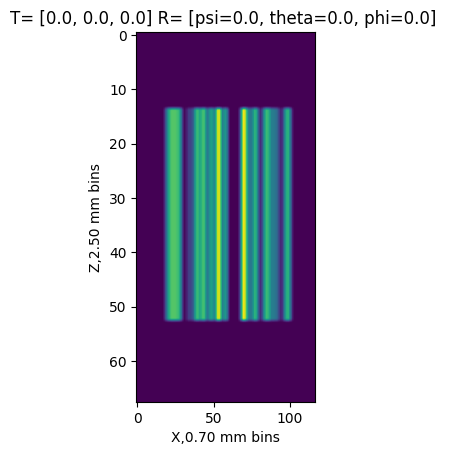

In [32]:
ThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumX[192:309,32:100].T),aspect=ThisAspect)
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Text(0.5, 1.0, 'T= [0.0, 0.0, 0.0] R= [psi=0.0, theta=0.0, phi=0.0] ')

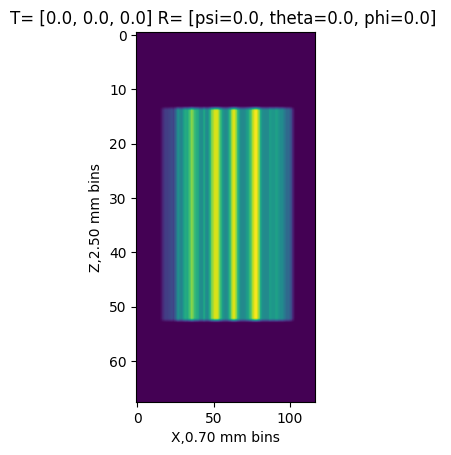

In [33]:
xThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumY[192:309,32:100].T),aspect=ThisAspect)
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

##Make DRRs for PVCvolume

In [34]:
volume=PVCvolume

Get characteristics of volume

In [35]:
ic(volume.dtype)
ic(volume.shape)
ic(volume.size)

ic| volume.dtype: dtype('float32')
ic| volume.shape: (512, 512, 133)
ic| volume.size: 34865152


34865152

Initialize the MyDRR module for generating synthetic X-rays

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drr = MyDRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)

In [37]:
rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)

Also note that DiffDRR can take many representations of SO(3) 📸

For example, quaternions, rotation matrix, axis-angle, etc...

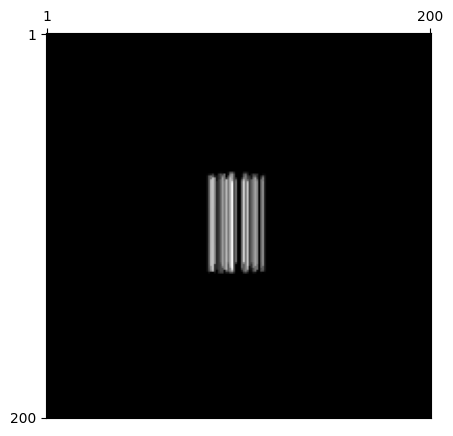

In [38]:
img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=True)
plt.show()

Get size of image

In [39]:
ic(img.shape)

ic| img.shape: torch.Size([1, 1, 200, 200])


torch.Size([1, 1, 200, 200])

## DRR Generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

Display Object from this camera's perspective

ic| rotations: tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0')
ic| translations: tensor([[180.0000, 180.0000, 166.2500]], device='cuda:0')


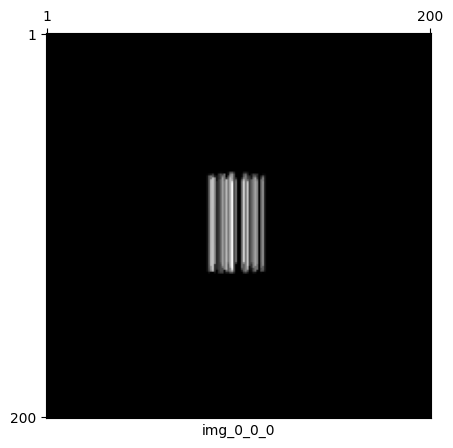

In [40]:
#| cuda
# Read in the volume and get the isocenter
#volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=300.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,  # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
ic(rotations)
ic(translations)
img_0_0_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img_0_0_0, ticks=True, title='img_0_0_0')
plt.show()

## notebooks/api/04_visualization.ipynb

2D Visualization
Uses matplotlib and imageio to plot DRRs and animate optimization over DRRs.

In [41]:
def plot_drr(
    img: torch.Tensor,
    title: str | None = None,
    ticks: bool | None = True,
    axs: matplotlib.axes._axes.Axes | None = None,
    cmap: str = "gray",
    **imshow_kwargs,
):
    """Plot an image generated by a DRR module."""

    if axs is None:
        fig, axs = plt.subplots(ncols=len(img), figsize=(10, 5))
    if len(img) == 1:
        axs = [axs]
    for img, ax in zip(img, axs):
        ax.imshow(img.squeeze().cpu().detach(), cmap=cmap, **imshow_kwargs)
        _, height, width = img.shape
        ax.xaxis.tick_top()
        ax.set(
            xlabel=title,
            xticks=[0, width - 1],
            xticklabels=[1, width],
            yticks=[0, height - 1],
            yticklabels=[1, height],
        )
        if ticks is False:
            ax.set_xticks([])
            ax.set_yticks([])
    return axs

In [42]:
ic(img_0_0_0.shape)
img2=torch.squeeze(img_0_0_0)
Img_0_0_0=img2.cpu().numpy()
ic(Img_0_0_0.shape)

ic| img_0_0_0.shape: torch.Size([1, 1, 200, 200])
ic| Img_0_0_0.shape: (200, 200)


(200, 200)

## Display object principal ray projection along x axis

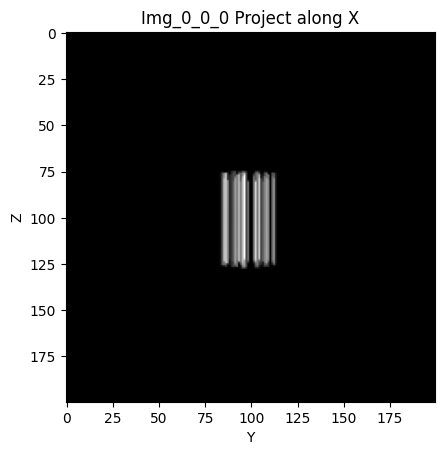

In [43]:
plt.imshow(np.flipud(Img_0_0_0),cmap='gray')
plt.title(f'Img_0_0_0 Project along X')
plt.xlabel(f'Y')
plt.ylabel(f'Z')
plt.show()

Translate Source by [100,0,0]
by translating camera by [-100,0,0]


ic| rotations: tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0')
ic| translations: tensor([[ 80.0000, 180.0000, 166.2500]], device='cuda:0')


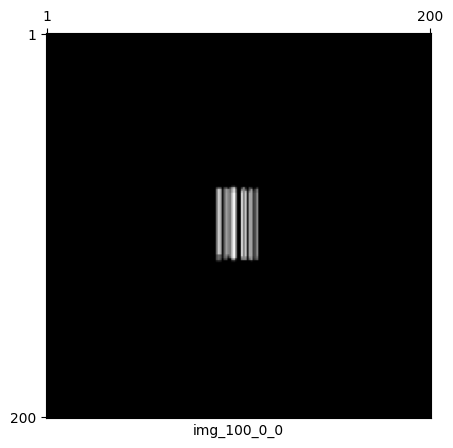

In [44]:
bx2=bx-100
by2=by+0
bz2=bz+0
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
img_100_0_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img_100_0_0, ticks=True,title='img_100_0_0')
plt.show()

ic| img_100_0_0.shape: torch.Size([1, 1, 250, 250])
ic| Img_100_0_0.shape: (250, 250)


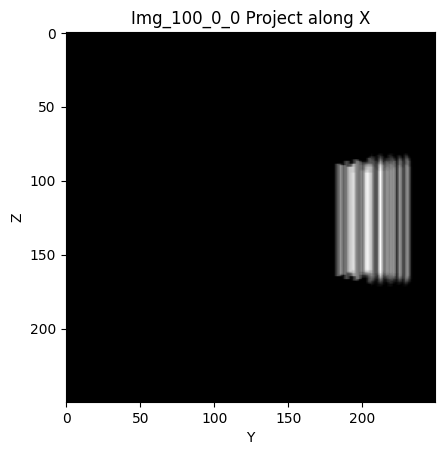

In [71]:
ic(img_100_0_0.shape)
img2=torch.squeeze(img_100_0_0)
Img_100_0_0=img2.cpu().numpy()
ic(Img_100_0_0.shape)
plt.imshow(np.flipud(Img_100_0_0),cmap='gray')
plt.title(f'Img_100_0_0 Project along X')
plt.xlabel(f'Y')
plt.ylabel(f'Z')
plt.show()

Translate Source by [0,100,0]
by translating camera by [0,-100,0]

ic| rotations: tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0')
ic| translations: tensor([[180.0000,  80.0000, 166.2500]], device='cuda:0')


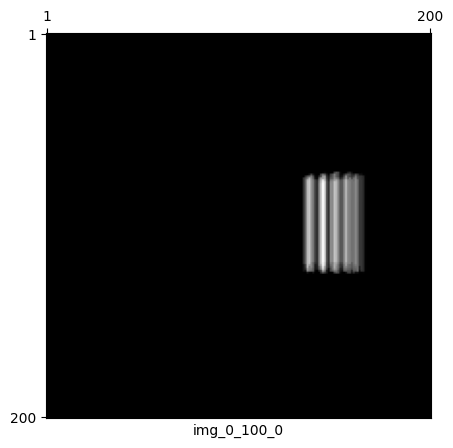

In [46]:
bx2=bx+0
by2=by-100
bz2=bz+0
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
img_0_100_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img_0_100_0, ticks=True,title='img_0_100_0')
plt.show()

ic| img_0_100_0.shape: torch.Size([1, 1, 200, 200])
ic| Img_0_100_0.shape: (200, 200)


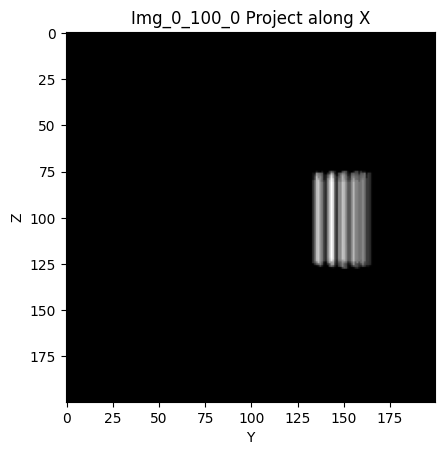

In [66]:
ic(img_0_100_0.shape)
img2=torch.squeeze(img_0_100_0)
Img_0_100_0=img2.cpu().numpy()
ic(Img_0_100_0.shape)
plt.imshow(np.flipud(Img_0_100_0),cmap='gray')
plt.title(f'Img_0_100_0 Project along X')
plt.xlabel(f'Y')
plt.ylabel(f'Z')
plt.show()

Translate Source by [0, 0,100
by translating Camera by [0, 0, -100]

ic| rotations: tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0')
ic| translations: tensor([[180.0000, 180.0000, 266.2500]], device='cuda:0')


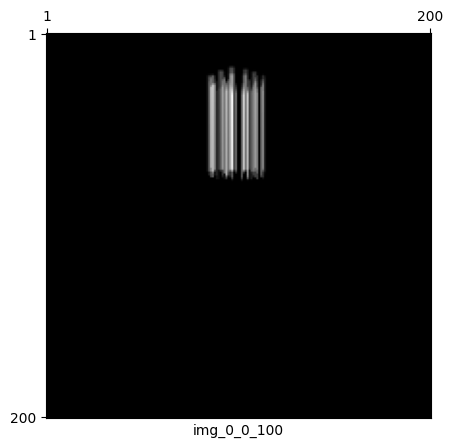

In [48]:
bx2=bx+0
by2=by+0
bz2=bz-100
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
img_0_0_100 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img_0_0_100, ticks=True,title='img_0_0_100')
plt.show()

ic| img_0_0_100.shape: torch.Size([1, 1, 200, 200])
ic| Img_0_0_100.shape: (200, 200)


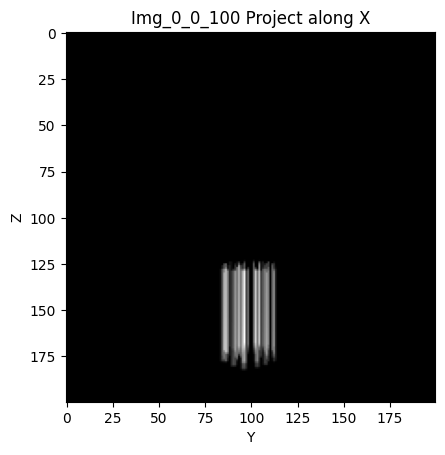

In [67]:
ic(img_0_0_100.shape)
img2=torch.squeeze(img_0_0_100)
Img_0_0_100=img2.cpu().numpy()
ic(Img_0_0_100.shape)
plt.imshow(np.flipud(Img_0_0_100),cmap='gray')
plt.title(f'Img_0_0_100 Project along X')
plt.xlabel(f'Y')
plt.ylabel(f'Z')
plt.show()

## Display same object from "Plan View" orthogonal to principal axis for this camera

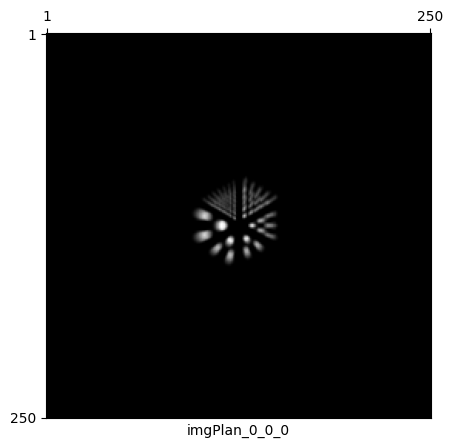

In [147]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
imgPlan_0_0_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(imgPlan_0_0_0, ticks=True,title='imgPlan_0_0_0')
plt.show()

ic| imgPlan_0_0_0.shape: torch.Size([1, 1, 250, 250])
ic| Img_100_0_0.shape: (250, 250)


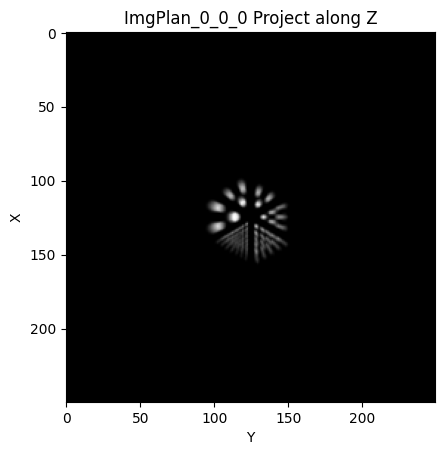

In [153]:
ic(imgPlan_0_0_0.shape)
img2=torch.squeeze(imgPlan_0_0_0)
ImgPlan_0_0_0=img2.cpu().numpy()
ic(Img_100_0_0.shape)
plt.imshow(np.flipud(ImgPlan_0_0_0),cmap='gray')
plt.title(f'ImgPlan_0_0_0 Project along Z')
plt.xlabel(f'Y')
plt.ylabel(f'X')
plt.show()

Translate Source by [100,0,0]
by translating camera by [-100,0,0]


ic| rotations: tensor([[3.1416, 1.5708, 1.5708]], device='cuda:0')
ic| translations: tensor([[ 80.0000, 180.0000, 166.2500]], device='cuda:0')


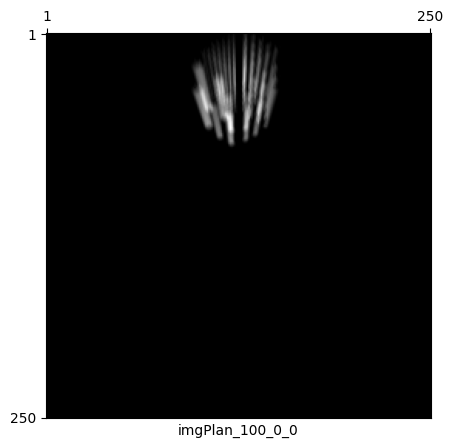

In [154]:
bx2=bx-100
by2=by+0
bz2=bz+0
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
imgPlan_100_0_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(imgPlan_100_0_0, ticks=True,title='imgPlan_100_0_0')
plt.show()

ic| imgPlan_100_0_0.shape: torch.Size([1, 1, 250, 250])
ic| ImgPlan_100_0_0.shape: (250, 250)


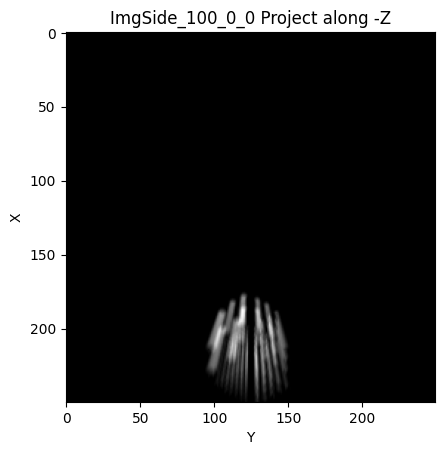

In [162]:
ic(imgPlan_100_0_0.shape)
img2=torch.squeeze(imgPlan_100_0_0)
ImgPlan_100_0_0=img2.cpu().numpy()
ic(ImgPlan_100_0_0.shape)
plt.imshow(np.flipud(ImgPlan_100_0_0),cmap='gray')
plt.title(f'ImgSide_100_0_0 Project along -Z')
plt.xlabel(f'Y')
plt.ylabel(f'X')
plt.show()

Translate Source by [0,100,0]
by translating camera by [0,-100,0]

ic| rotations: tensor([[3.1416, 1.5708, 1.5708]], device='cuda:0')
ic| translations: tensor([[180.0000,  80.0000, 166.2500]], device='cuda:0')


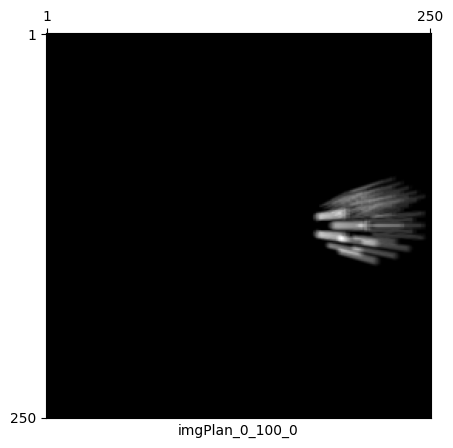

In [156]:
bx2=bx+0
by2=by-100
bz2=bz+0
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
imgPlan_0_100_0 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(imgPlan_0_100_0, ticks=True,title='imgPlan_0_100_0')
plt.show()

ic| imgPlan_0_100_0.shape: torch.Size([1, 1, 250, 250])
ic| ImgPlan_0_100_0.shape: (250, 250)


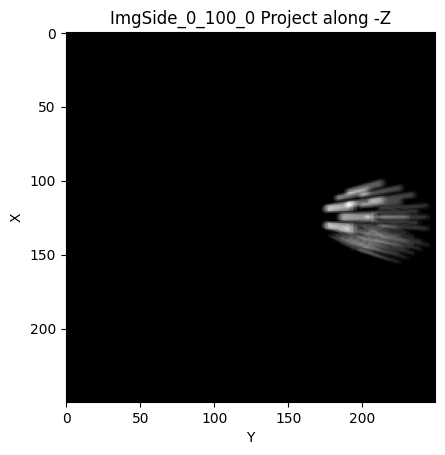

In [163]:
ic(imgPlan_0_100_0.shape)
img2=torch.squeeze(imgPlan_0_100_0)
ImgPlan_0_100_0=img2.cpu().numpy()
ic(ImgPlan_0_100_0.shape)
plt.imshow(np.flipud(ImgPlan_0_100_0),cmap='gray')
plt.title(f'ImgSide_0_100_0 Project along -Z')
plt.xlabel(f'Y')
plt.ylabel(f'X')
plt.show()

Translate Source by [0, 0,100
by translating Camera by [0, 0, -100]

ic| rotations: tensor([[3.1416, 1.5708, 1.5708]], device='cuda:0')
ic| translations: tensor([[180.0000, 180.0000,  66.2500]], device='cuda:0')


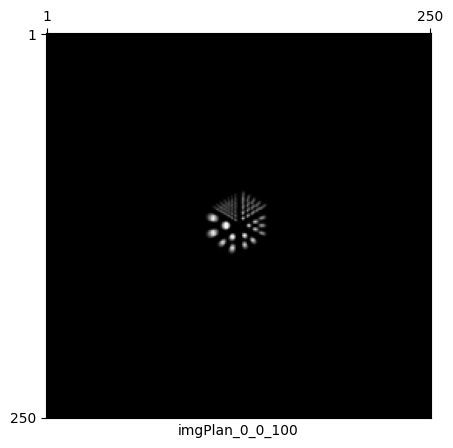

In [160]:
bx2=bx+0
by2=by+0
bz2=bz-100
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[bx2, by2, bz2]], device=device)
ic(rotations)
ic(translations)
imgPlan_0_0_100 = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(imgPlan_0_0_100, ticks=True,title='imgPlan_0_0_100')
plt.show()

ic| imgPlan_0_0_100.shape: torch.Size([1, 1, 250, 250])
ic| ImgPlan_0_0_100.shape: (250, 250)


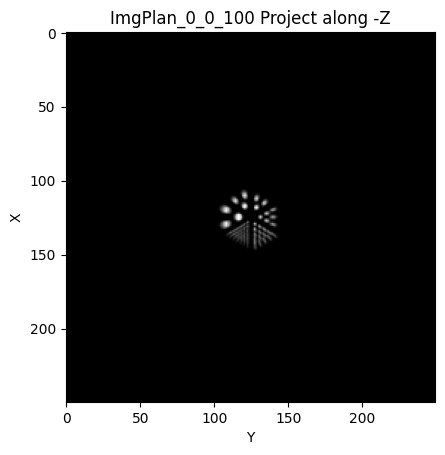

In [164]:
ic(imgPlan_0_0_100.shape)
img2=torch.squeeze(imgPlan_0_0_100)
ImgPlan_0_0_100=img2.cpu().numpy()
ic(ImgPlan_0_0_100.shape)
plt.imshow(np.flipud(ImgPlan_0_0_100),cmap='gray')
plt.title(f'ImgPlan_0_0_100 Project along -Z')
plt.xlabel(f'Y')
plt.ylabel(f'X')
plt.show()

Install matplotlib and numpy

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

!pip install icecream
from icecream import ic

Input from .xlsx file

MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.fix

From Google drive

In [52]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/SPECTGeometry/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
!ls -ltr /content/drive/MyDrive/SPECTGeometry/

total 1223
-rw------- 1 root root 461819 Dec 19 14:27 MDSL.excel80M10RFR.cut-plate.007.150roi.2.30pin.105ellipse.fix.xlsx
-rw------- 1 root root 790185 Dec 22 19:19 MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx


Install openpyxl using pip

In [54]:
pip install openpyxl

https://openpyxl.readthedocs.io/en/stable/tutorial.html#loading-from-a-file

In [55]:
from openpyxl import load_workbook
wb = load_workbook(filename = '/content/drive/MyDrive/SPECTGeometry/MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx',data_only=True)

loop through worksheets

In [56]:
for sheet in wb:
...     print(sheet.title)

Main
Coordinates
MDSL cloud import
Theta
Values
Design Table


Go to Coordinates Worksheet

In [57]:
wb.active = 1
print(wb.active.title)
ws = wb.active

Coordinates


Length of Collimator

In [58]:
ic(ws.cell(2,7).value)
lcoll=np.zeros(80)
for i in range(3,83):
  lcoll[i-3]=(ws.cell(i,7).value)

ic| ws.cell(2,7).value: 'length of collimator'


Choose vsdr = 5 * length of collimato

In [59]:
vsdr=5.*lcoll

alpha: Azimuthal angle (radians)

In [60]:
ic(ws.cell(2,22).value)
alpha=np.zeros(80)
for i in range(3,83):
  alpha[i-3]=(ws.cell(i,22).value)

ic| ws.cell(2,22).value: 'pinhole azimuth (radians)'


beta = altitude (radians)

In [61]:
ic(ws.cell(2,23).value)
beta=np.zeros(80)
for i in range(3,83):
  beta[i-3]=(ws.cell(i,23).value)

ic| ws.cell(2,23).value: 'pinhole elevation (radians)'


DRR Generation

DiffDRR is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd. This also means that DRR generation is available as a layer in deep learning frameworks.

Display Wide FOV for camera [0]

ic| bx0.dtype: torch.float32
ic| bx.dtype: torch.float32
ic| rotations0: tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0')
ic| rotations0.dtype: torch.float32
ic| rotations: tensor([[ 0.2488, -0.2403,  1.5708]], device='cuda:0')
ic| rotations.dtype: torch.float32
ic| img.shape: torch.Size([1, 1, 250, 250])
ic| imgMax: tensor(19.3384, device='cuda:0')


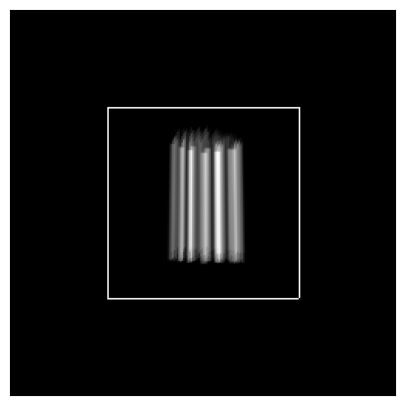

In [62]:
#| cuda
# Read in the volume and get the isocenter
#volume, spacing = load_example_ct()
bx0, by0, bz0 = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx0.dtype)
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx.dtype)
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr0 = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=300.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,  # Pixel spacing (in mm)
).to(device)
drr1 = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[0]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.25,  # Pixel spacing (in mm)
).to(device)
drr2 = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[0]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.50,  # Pixel spacing (in mm)
).to(device)

drr=drr2

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations0 = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
ic(rotations0)
ic(rotations0.dtype)
rotations = torch.tensor([[float(alpha[0]), float(beta[0]), torch.pi / 2]], device=device)
ic(rotations)
ic(rotations.dtype)
translations0 = torch.tensor([[bx0, by0, bz0]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
#img = drr0(rotations0, translations0, parameterization="euler_angles", convention="ZYX")
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
ic(img.shape)
imgMax=img.max()
img[0,0,63:187,63] = imgMax
img[0,0,63:187,187] = imgMax
img[0,0,63,63:187] = imgMax
img[0,0,187,63:187] = imgMax
ic(imgMax)
plot_drr(img, ticks=False)
plt.show()

Adapted from diffdrr/visualization.py/plot_drr

Display Wide FOV for camera [10]

ic| rotations: tensor([[ 2.6307, -0.3508,  1.5708]], device='cuda:0')
ic| rotations.dtype: torch.float32
ic| img.shape: torch.Size([1, 1, 250, 250])
ic| imgMax: tensor(16.4447, device='cuda:0')


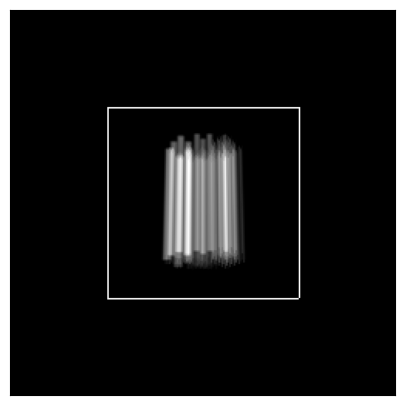

In [63]:
rotations = torch.tensor([[float(alpha[10]), float(beta[10]), torch.pi / 2]], device=device)
ic(rotations)
ic(rotations.dtype)
translations0 = torch.tensor([[bx0, by0, bz0]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
#img = drr0(rotations0, translations0, parameterization="euler_angles", convention="ZYX")
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
ic(img.shape)
imgMax=img.max()
img[0,0,63:187,63] = imgMax
img[0,0,63:187,187] = imgMax
img[0,0,63,63:187] = imgMax
img[0,0,187,63:187] = imgMax
ic(imgMax)
plot_drr(img, ticks=False)
plt.show()

Display Wide FOV Series for cameras [0:19]

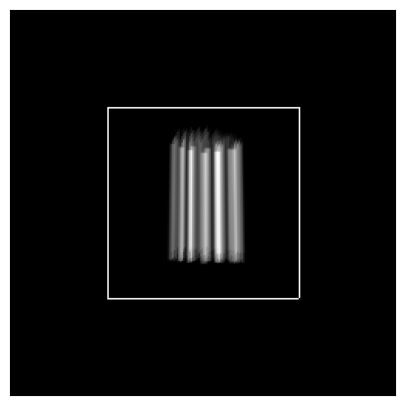

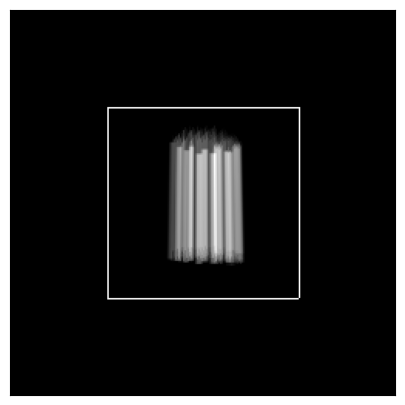

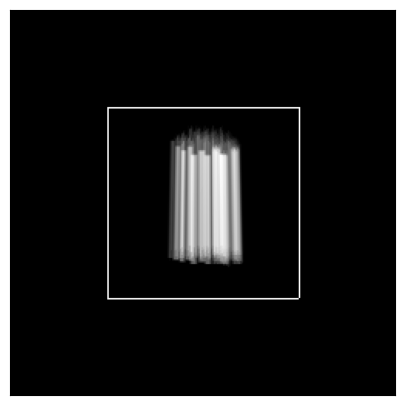

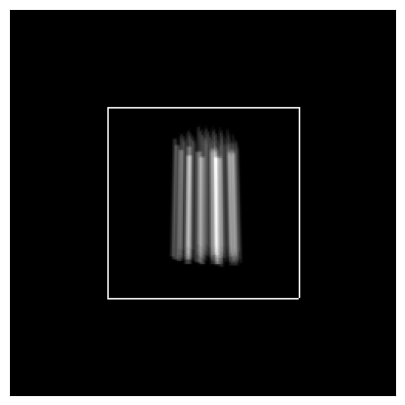

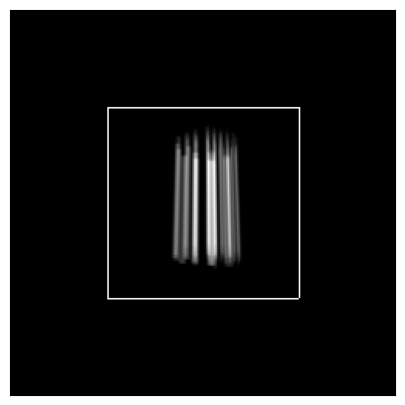

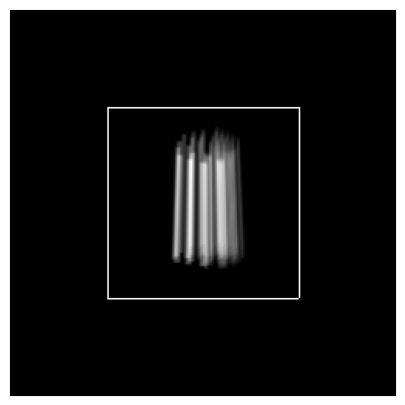

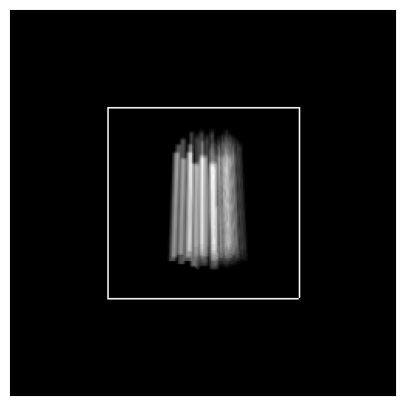

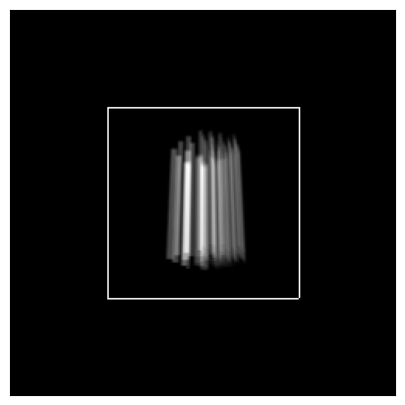

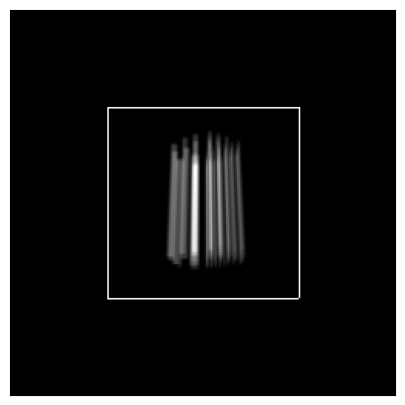

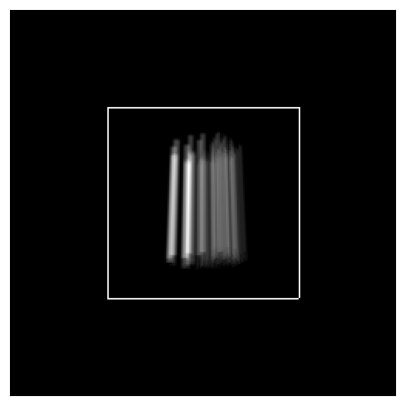

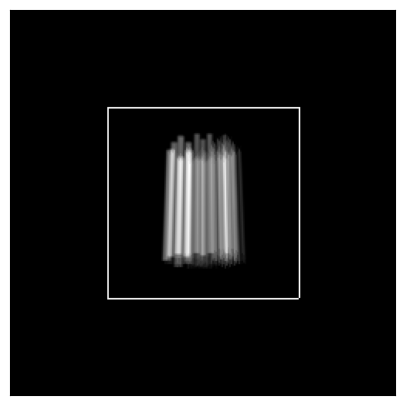

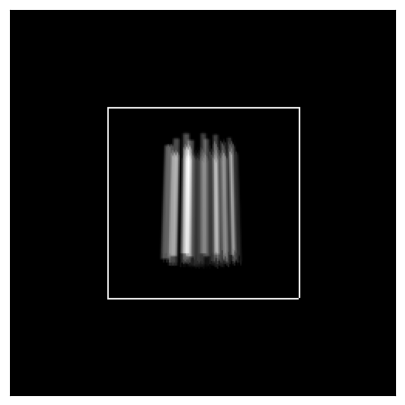

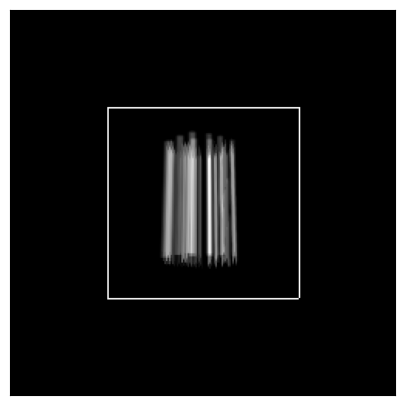

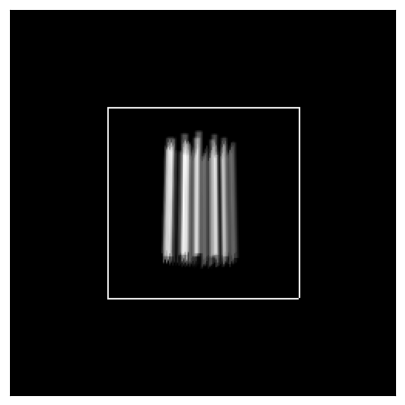

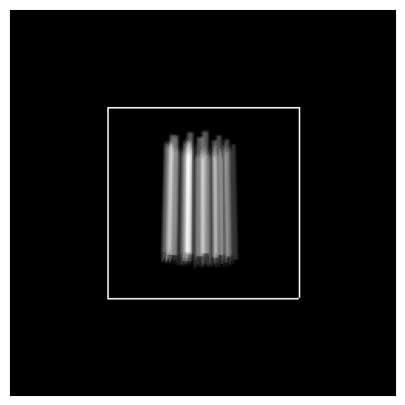

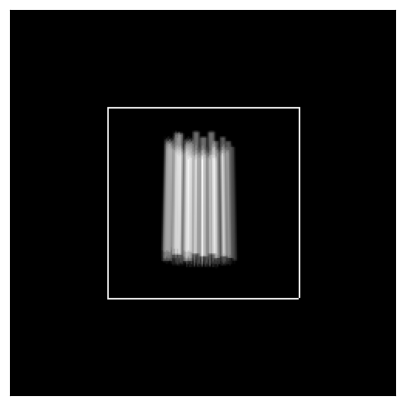

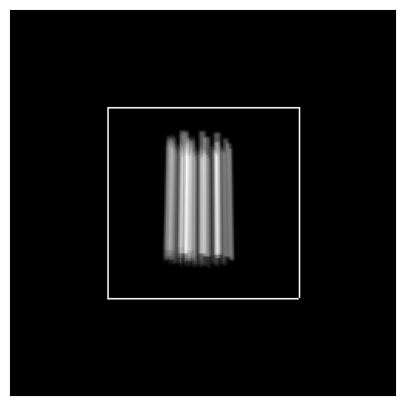

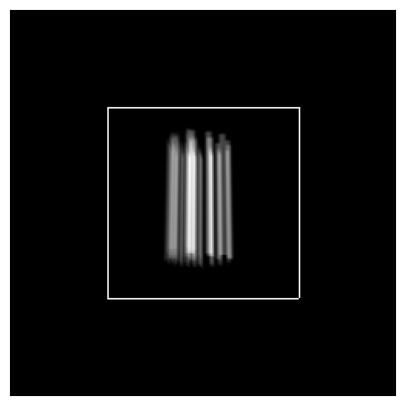

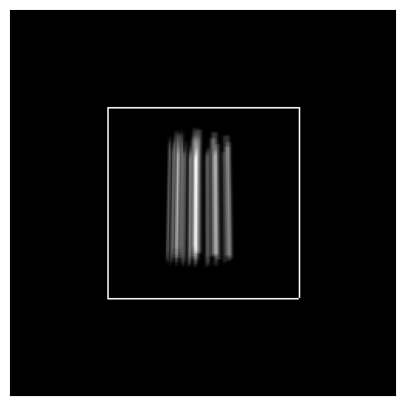

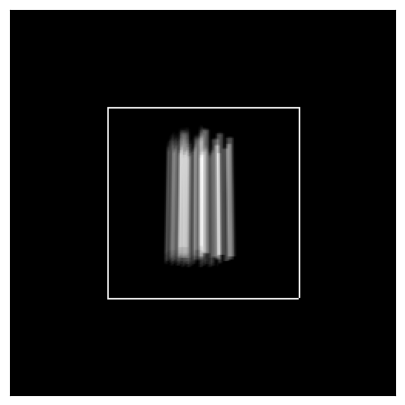

ic| img.shape: torch.Size([1, 1, 250, 250])


torch.Size([1, 1, 250, 250])

In [64]:
for imod in range(0,20):
  drr = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.50,  # Pixel spacing (in mm)
  ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
  rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
  translations = torch.tensor([[bx, by, bz]], device=device)
  img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
  imgMax=img.max()
  img[0,0,63:187,63] = imgMax
  img[0,0,63:187,187] = imgMax
  img[0,0,63,63:187] = imgMax
  img[0,0,187,63:187] = imgMax
  plot_drr(img, ticks=False)
  plt.show()

ic(img.shape)

Compact Wide FOV Display for all 80 modules

In [65]:
#BigImage=torch.zeros(4,250,20,250)
BigImage=img.tile(4,20).resize(4,250,20,250)
ic(BigImage.shape)

#for iRow in range(0,4):
#  for iCol in range(0,20):
for iRow in range(0,4):
  for iCol in range(0,20):
    imod=iRow*20+iCol

    drr = MyDRR(
        volume,  # The CT volume as a numpy array
        spacing,  # Voxel dimensions of the CT
        sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
        height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
        delx=2.50,  # Pixel spacing (in mm)
          ).to(device)

    # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
    imgMax=img.max()
    img[0,0,63:187,63] = imgMax
    img[0,0,63:187,187] = imgMax
    img[0,0,63,63:187] = imgMax
    img[0,0,187,63:187] = imgMax
    BigImage[iRow,:,iCol,:]=img[0,0,:,:]

ic(BigImage.shape)
BigImage=BigImage.reshape(1,1,1000,5000)
ic(BigImage.shape)
plot_drr(BigImage, ticks=False)
plt.show()

ic(img.shape)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
ic| BigImage.shape: torch.Size([4, 250, 20, 250])


KeyboardInterrupt: 

Display FOV Series for cameras [0:19]

In [ ]:
for imod in range(0,20):
  drr = MyDRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.25,  # Pixel spacing (in mm)
  ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
  rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
  translations = torch.tensor([[bx, by, bz]], device=device)
  img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
  imgMax=img.max()
  img[0,0,0:249,0] = imgMax
  img[0,0,0:249,249] = imgMax
  img[0,0,0,0:249] = imgMax
  img[0,0,249,0:249] = imgMax
  plot_drr(img, ticks=False)
  plt.show()

ic(img.shape)

Compact FOV Display for all 80 modules

In [ ]:
#BigImage=torch.zeros(4,250,20,250)
BigImage=img.tile(4,20).resize(4,250,20,250)
ic(BigImage.shape)

#for iRow in range(0,4):
#  for iCol in range(0,20):
for iRow in range(0,4):
  for iCol in range(0,20):
    imod=iRow*20+iCol

    drr = MyDRR(
        volume,  # The CT volume as a numpy array
        spacing,  # Voxel dimensions of the CT
        sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
        height=250,  # Height of the DRR (if width is not seperately provided, the generated image is square)
        delx=1.25,  # Pixel spacing (in mm)
          ).to(device)

    # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
    imgMax=img.max()
    img[0,0,0:249,0] = imgMax
    img[0,0,0:249,249] = imgMax
    img[0,0,0,0:249] = imgMax
    img[0,0,249,0:249] = imgMax
    BigImage[iRow,:,iCol,:]=img[0,0,:,:]

ic(BigImage.shape)
BigImage=BigImage.reshape(1,1,1000,5000)
ic(BigImage.shape)
plot_drr(BigImage, ticks=False)
plt.show()

ic(img.shape)